In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from rich.console import Console

import tree_segmentation as ts
import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from tree_segmentation import Tree3Dv2, Tree3D, TreePredictor, TreeSegmentMetric, Tree2D
from tree_segmentation.util import show_masks, show_all_levels, get_hash_name, color_mask, get_colored_masks, image_add_mask_boundary
from evaluation.eval_PartNet import load_images
from tree_segmentation.render import render_mesh
from paper.paper_util import save_3d_part_meshs, save_3d_view
import matplotlib.image as mpimg
import networkx as nx
import cv2


/home/wan/Projects/Segmentation/TreeSeg


In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
# device = torch.device("cuda")
device = torch.device("cpu")
utils.set_printoptions(linewidth=120)
glctx = dr.RasterizeCudaContext()

In [8]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
# cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
print(f"Data Root: {data_root}")
image_dir = data_root.parent.joinpath('tree_seg')

save_root = Path('/data5/wan/PartNet_final/').expanduser()
print(f"Save Root:", save_root)
all_results = sorted(list(save_root.glob('*/my.tree3dv2')))
print(f'There are {len(all_results)} results')

categories = set()
results = {}

for result_path in all_results:
    obj_id = result_path.parts[-2]
    print(result_path, obj_id)
    assert data_root.joinpath(obj_id).exists()
    with data_root.joinpath(obj_id, 'meta.json').open('r') as f:
        meta = json.load(f)
        cat = meta['model_cat']
    categories.add(cat)
    if cat not in results:
        results[cat] = []
    results[cat].append(result_path)

categories = list(categories)
print(f"Categories: {len(categories)}")
for cat in categories:
    print(f'Cat: {cat} have {len(results[cat])} results')


Data Root: /home/wan/data/PartNet/data_v0
Save Root: /data5/wan/PartNet_final
There are 269 results
/data5/wan/PartNet_final/10096/my.tree3dv2 10096
/data5/wan/PartNet_final/10129/my.tree3dv2 10129
/data5/wan/PartNet_final/10201/my.tree3dv2 10201
/data5/wan/PartNet_final/10219/my.tree3dv2 10219
/data5/wan/PartNet_final/10276/my.tree3dv2 10276
/data5/wan/PartNet_final/10289/my.tree3dv2 10289
/data5/wan/PartNet_final/10368/my.tree3dv2 10368
/data5/wan/PartNet_final/10399/my.tree3dv2 10399
/data5/wan/PartNet_final/1046/my.tree3dv2 1046
/data5/wan/PartNet_final/1051/my.tree3dv2 1051
/data5/wan/PartNet_final/10577/my.tree3dv2 10577
/data5/wan/PartNet_final/10582/my.tree3dv2 10582
/data5/wan/PartNet_final/10610/my.tree3dv2 10610
/data5/wan/PartNet_final/10644/my.tree3dv2 10644
/data5/wan/PartNet_final/10658/my.tree3dv2 10658
/data5/wan/PartNet_final/10871/my.tree3dv2 10871
/data5/wan/PartNet_final/10900/my.tree3dv2 10900
/data5/wan/PartNet_final/10962/my.tree3dv2 10962
/data5/wan/PartNet_fin

In [12]:
scores = {}
all_metrics = {}
for cat in categories:
    scores[cat] = []
    metric = TreeSegmentMetric()
    for result_path in results[cat]:  # type: Path
        # print(result_path)
        mesh = torch.load(result_path.with_name(f'{result_path.parts[-2]}.mesh_cache'), map_location=device)
        # print(mesh)
        gt = Tree3Dv2(mesh, device=device)
        gt.load(result_path.with_name('gt.tree3dv2'))
        if gt.cnt == 0:
            continue

        prediction = Tree3Dv2(mesh, device=device)
        prediction.load(result_path)

        metric_t = TreeSegmentMetric()
        metric_t.update(prediction, gt)
        scores[cat].append(metric_t.TQ)
        metric.update(prediction, gt)

    all_metrics[cat] = metric

[Tree3D] load results from: /data5/wan/PartNet_final/14277/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14277/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14501/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14501/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14814/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14814/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14818/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14818/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14973/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/14973/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/15071/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/15071/my.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/15381/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet_final/15381/my.tree3dv2
[Tree3

In [24]:
# show_cats = ['Bag', 'Bed', 'Bottle', 'Bowl', 'Chair', 'Clock', 'Dishwasher', 'Display', 'Door', 'Earphone', 'Faucet', 'Hat', 'Keyboard', 'Knife', 'Lamp', 'Laptop', 'Microwave', 'Mug', 'Refrigerator', 'Scissors', 'StorageFurniture', 'Table', 'TrashCan', 'Vase']
show_cats = [
    'Bed', 'Chair', 'Clock', 'Dishwasher', 'Display', 'Door', 'Earphone', 'Faucet', 'Knife', 'Lamp', 'Microwave',
    'Refrigerator', 'StorageFurniture', 'Table', 'Vase'
]
metric_names = ['SQ', 'RQ', 'TS', 'TQ', 'mTQ']
print(' & '.join([f"{'Cat':20}"] + [f"{s:6}" for s in metric_names]))
for cat in show_cats:
    if cat in categories:
        res = all_metrics[cat].summarize()
        print(' & '.join([f"{cat:20}"] + [f"{res[name]:.4f}" for name in metric_names]))

for name in metric_names:
    values = [getattr(all_metrics[cat], name) for cat in show_cats]
    print('ours', name, f"{np.mean(values):.4f}", *[f"{v:.4f}" for v in values], sep=' & ', end='\\\\\n')


Cat                  & SQ     & RQ     & TS     & TQ     & mTQ   
Bed                  & 0.1682 & 0.8042 & 0.9884 & 0.1390 & 0.1208
Chair                & 0.3814 & 0.7379 & 0.9864 & 0.2672 & 0.2374
Clock                & 0.2434 & 0.4962 & 0.9891 & 0.0874 & 0.1018
Dishwasher           & 0.2097 & 0.7108 & 0.9879 & 0.1364 & 0.1329
Display              & 0.4062 & 0.5551 & 0.9867 & 0.1998 & 0.2160
Door                 & 0.2756 & 0.6235 & 0.9891 & 0.1359 & 0.1281
Earphone             & 0.1805 & 0.7505 & 0.9869 & 0.1412 & 0.1266
Faucet               & 0.4052 & 0.6706 & 0.9840 & 0.2300 & 0.2145
Knife                & 0.6026 & 0.6093 & 0.9878 & 0.3212 & 0.3471
Lamp                 & 0.3759 & 0.5730 & 0.9890 & 0.1900 & 0.1736
Microwave            & 0.1236 & 0.7775 & 0.9908 & 0.0762 & 0.0635
Refrigerator         & 0.1652 & 0.6674 & 0.9898 & 0.0965 & 0.0638
StorageFurniture     & 0.1631 & 0.7224 & 0.9903 & 0.1169 & 0.0827
Table                & 0.3024 & 0.7130 & 0.9880 & 0.2096 & 0.1862
Vase      

In [25]:
index = 0
cat = categories[index]
scores_c = np.array(scores[cat])
order = np.argsort(scores_c)[::-1]
print('Now Category:', cat)
print('scores:', scores_c[order])

TypeError: 'set' object is not subscriptable

In [27]:
best_mesh = results[cat][order[1]]
mesh = torch.load(best_mesh.with_name(f'{best_mesh.parts[-2]}.mesh_cache'))
print(mesh)
gt = Tree3Dv2(mesh, device=device)
gt.load(best_mesh.with_name('gt.tree3dv2'))
gt.to(device)

prediction = Tree3Dv2(mesh, device=device)
prediction.load(best_mesh)
prediction.to(device)

images, tri_ids, Tw2v = load_images(mesh, image_dir.joinpath(cat, best_mesh.parent.name), num_views=100)
images = images.to(device)
tri_ids = tri_ids.to(device)
Tw2v = Tw2v.to(device)
mesh = mesh.to(device)
print(tri_ids.shape)

Mesh(vertices=41160, faces=20576)
[Tree3D] load results from: /data5/wan/PartNet/Lamp/16300/gt.tree3dv2
[Tree3D] load results from: /data5/wan/PartNet/Lamp/16300/my.tree3dv2
torch.Size([100, 1024, 1024])


index: 83


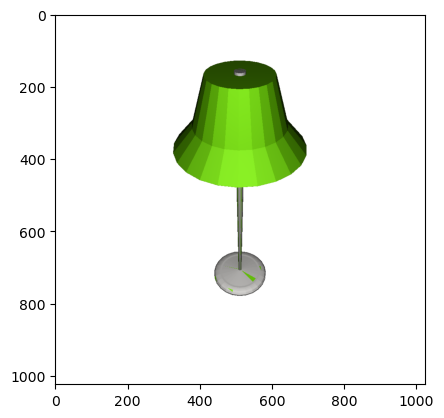

0: Tree Root
├── 1
├── 2
└── 3
    ├── 4
    └── 5

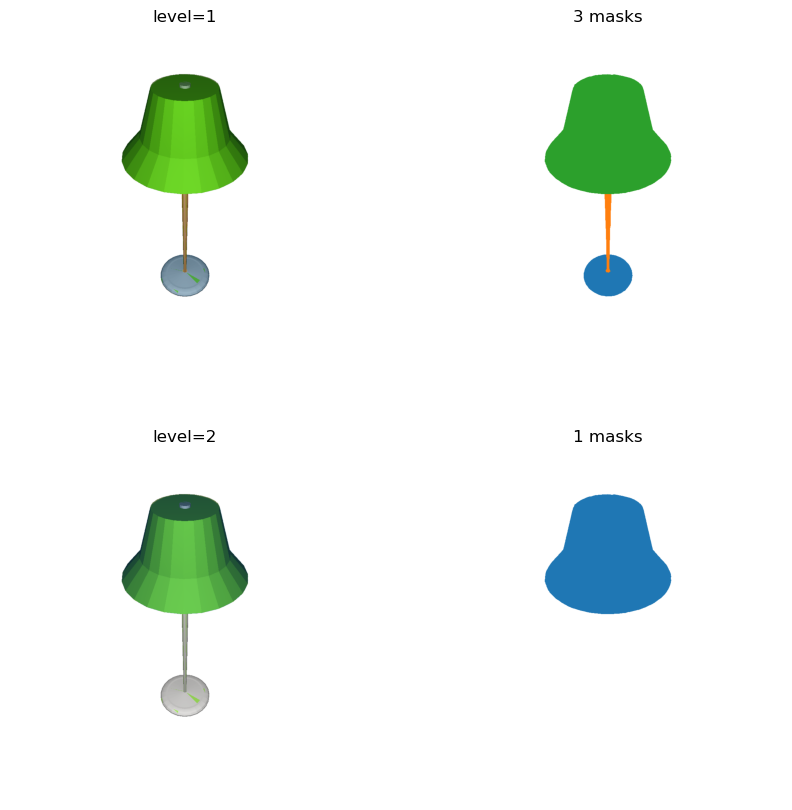

In [28]:
show_index = np.random.choice(len(images))
print('index:', show_index)
plt.imshow(images[show_index].cpu().numpy())
plt.show()
show_all_levels(images[show_index,], gt, tri_ids[show_index])
gt.print_tree()

In [29]:
# save_dir = Path(f'./results/PartNet_{cat}_gt/view{show_index}')
# save_dir.mkdir(exist_ok=True, parents=True)
# save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
# save_3d_part_meshs(save_dir.parent, gt, mesh)

0: Tree Root
└── 1
    ├── 2
    │   ├── 5
    │   └── 6
    │       ├── 9
    │       └── 10
    ├── 3
    │   ├── 7
    │   │   └── 11
    │   └── 8
    │       ├── 12
    │       └── 13
    └── 4

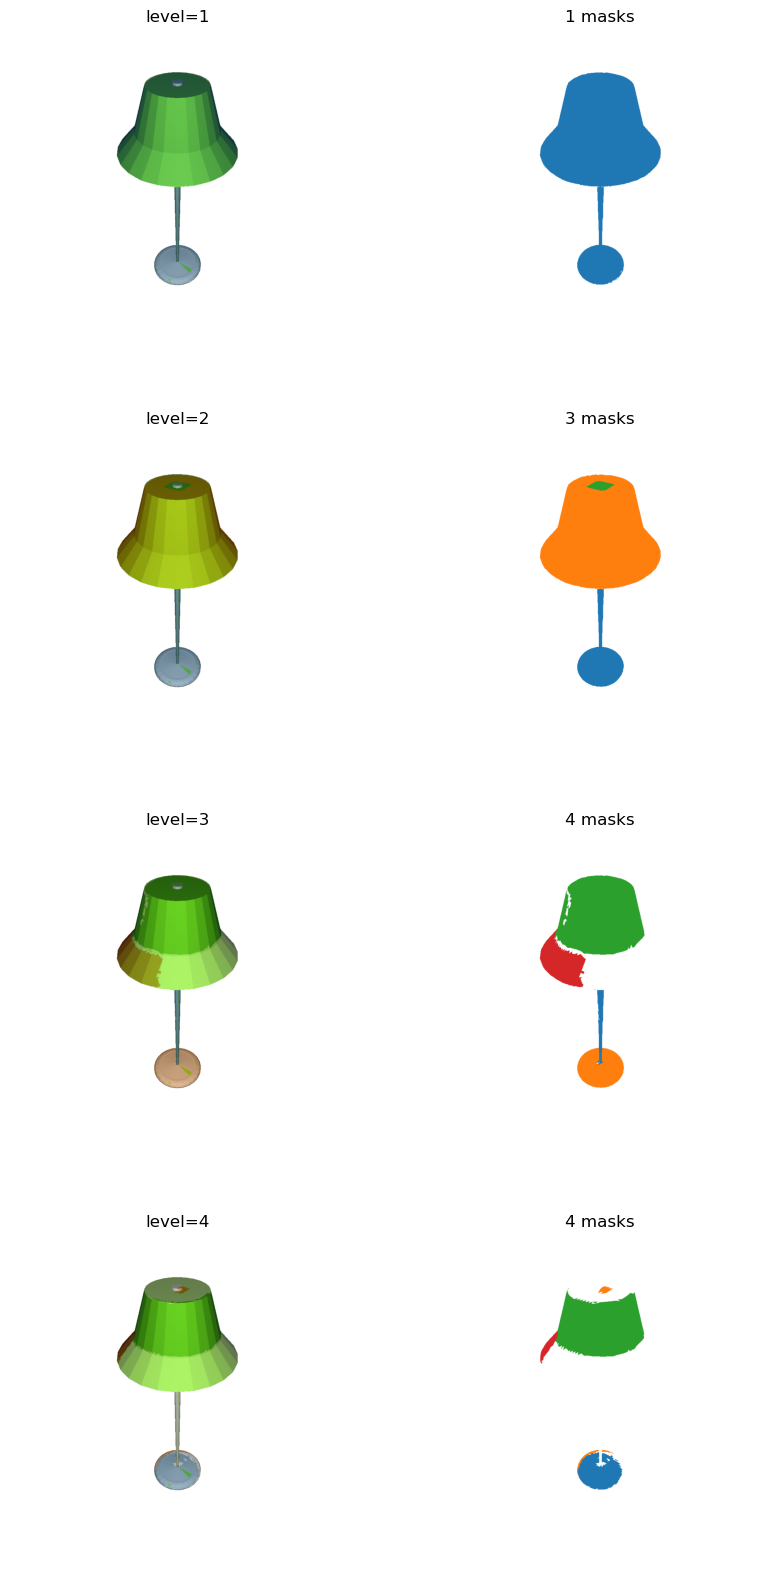

In [30]:
# show_index = 40
prediction.node_rearrange()
show_all_levels(images[show_index,], prediction, tri_ids[show_index])
prediction.print_tree()

In [31]:
# save_dir = Path(f'./results/PartNet_{cat}/view{show_index}')
# save_dir.mkdir(exist_ok=True, parents=True)
# save_3d_view(save_dir, gt, images[show_index], tri_ids[show_index])
# save_3d_part_meshs(save_dir.parent, gt, mesh)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


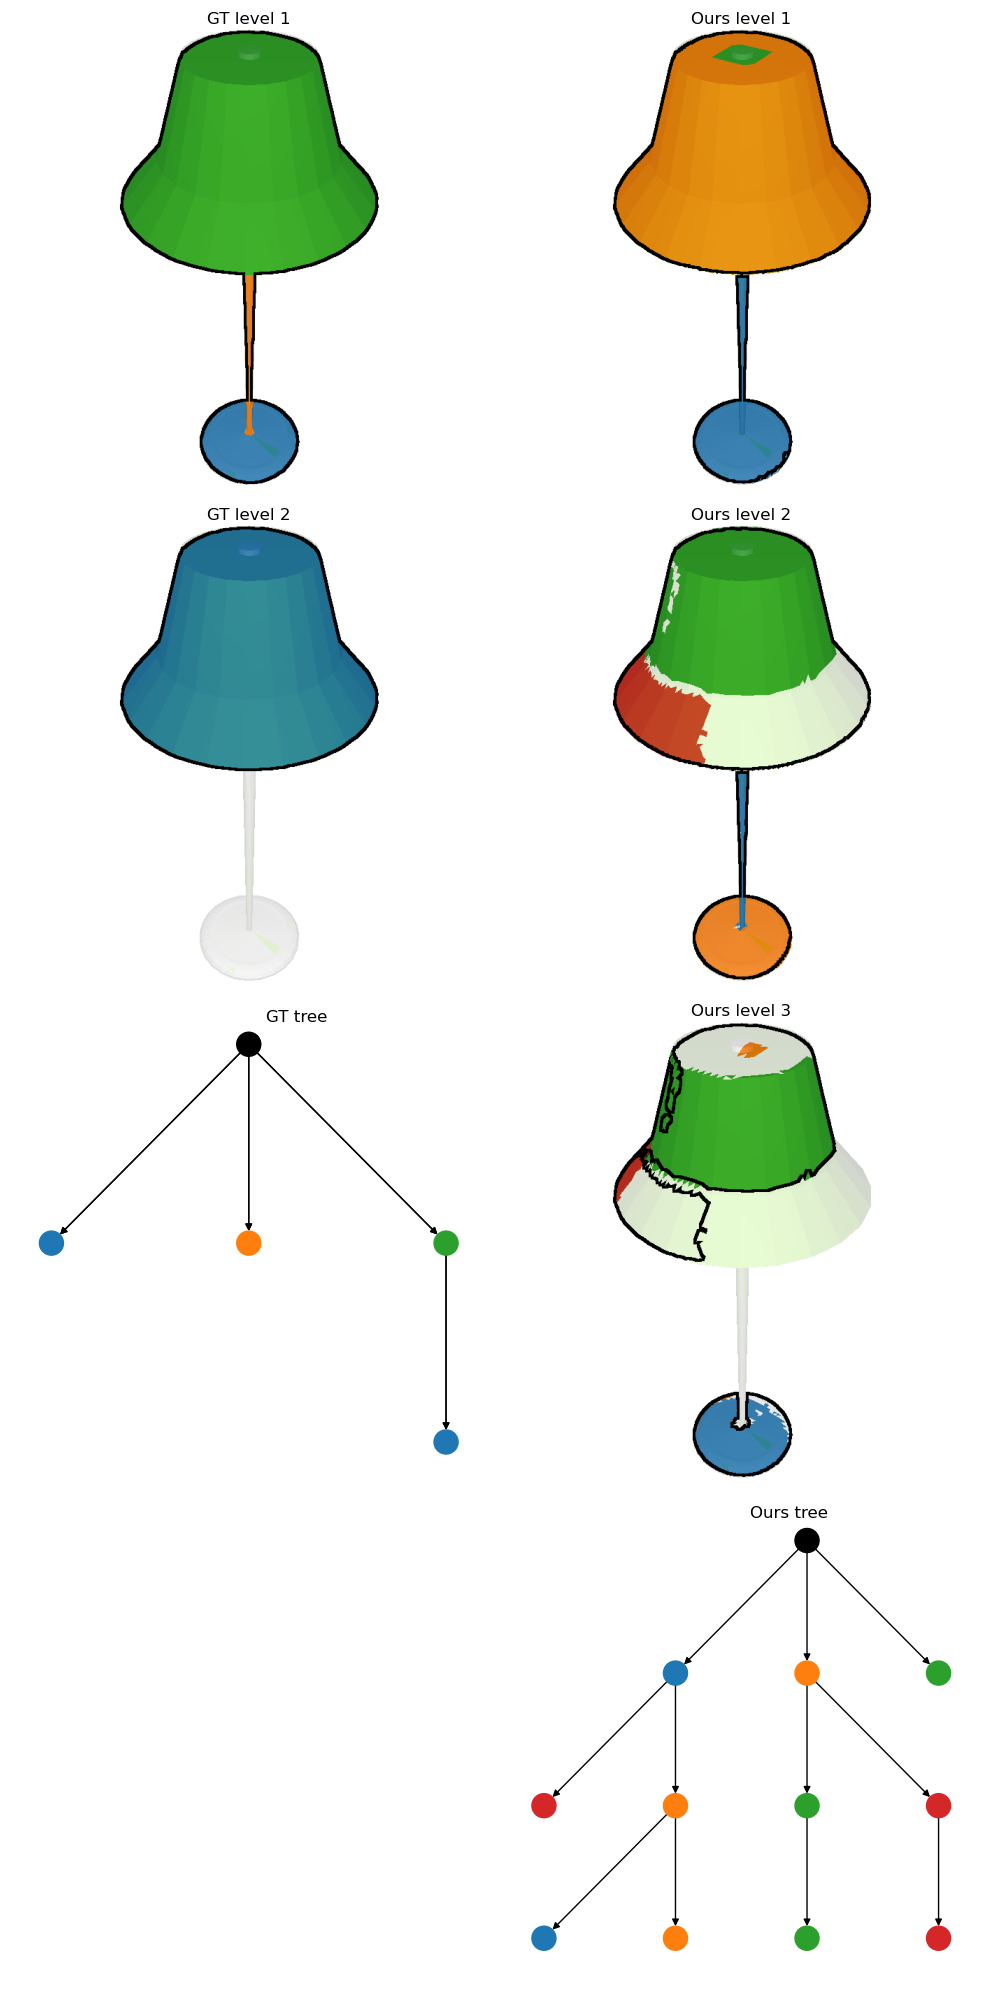

In [33]:
def show_compare(pred: Tree3Dv2, gt: Tree3Dv2, image: Tensor, tri_id: Tensor):
    if isinstance(image, Tensor):
        image = image.cpu().numpy()
    alpha = 0.2

    aux_data_p = pred.get_aux_data(tri_id)
    levels_p = pred.get_levels(aux_data_p)[2:]

    aux_data_g = gt.get_aux_data(tri_id)
    levels_g = gt.get_levels(aux_data_g)[1:]
    num_p = len(levels_p)
    num_g = len(levels_g)
    Gp_idx, Gg_idx = 0, 0
    if num_p >= num_g + 2:
        max_levels = num_p
        Gg_idx = num_g * 2 + 1
        Gp_idx = num_g * 2 + 3
    elif num_g - 1 <= num_p <= num_g + 1:
        max_levels = num_p + 1
        Gg_idx = num_g * 2 + 1
        Gp_idx = num_p * 2 + 2
    else:
        max_levels = num_g
        Gg_idx = num_p * 2 + 2
        Gp_idx = num_p * 2 + 4
    plt.figure(figsize=(5 * 2, 5 * max_levels))

    H, W = tri_id.shape
    mask = tri_id > 0
    row = torch.nonzero(mask.any(dim=1))
    col = torch.nonzero(mask.any(dim=0))
    left, right = max(0, col[0] - 20), min(W, col[-1] + 20)
    top, bottom = max(0, row[0] - 30), min(H, row[-1] + 10)

    Gg = nx.DiGraph()
    Gp = nx.DiGraph()
    node_colors_p = {}
    node_colors_g = {}

    for level in range(max_levels):
        if level < len(levels_g):
            plt.subplot(max_levels, 2, level * 2 + 1)
            masks = torch.stack([aux_data_g[x.item()][0] for x in levels_g[level]])
            # print(utils.show_shape(masks))
            img_m = get_colored_masks(masks)
            img_l = cv2.addWeighted(image, alpha, img_m, 1 - alpha, 0)
            for x in levels_g[level]:
                x = x.item()
                p = gt.parent[x].item()
                assert p in aux_data_g
                mask = aux_data_g[p][0]
                img_l = image_add_mask_boundary(img_l, mask, color=(0, 0, 0), kernel_size=9)
                Gg.add_edge(p, x)
                mask = aux_data_g[x][0]
                pos = torch.nonzero(mask)[0]
                node_colors_g[x] = img_m[pos[0], pos[1]]

            plt.imshow(img_l[top:bottom, left:right])
            plt.axis('off')
            plt.title(f'GT level {level+1}', y=1.0, pad=-10)
        if level < len(levels_p):
            plt.subplot(max_levels, 2, level * 2 + 2)
            masks = torch.stack([aux_data_p[x.item()][0] for x in levels_p[level]])
            img_m = get_colored_masks(masks)
            img_l = cv2.addWeighted(image, alpha, img_m, 1 - alpha, 0)
            for x in levels_p[level]:
                x = x.item()
                p = pred.parent[x].item()
                assert p in aux_data_p
                mask = aux_data_p[p][0]
                img_l = image_add_mask_boundary(img_l, mask, color=(0, 0, 0), kernel_size=9)
                Gp.add_edge(p, x)
                mask = aux_data_p[x][0]
                pos = torch.nonzero(mask)[0]
                node_colors_p[x] = img_m[pos[0], pos[1]]
            plt.imshow(img_l[top:bottom, left:right])
            plt.axis('off')
            plt.title(f'Ours level {level+1}', y=1.0, pad=-10)
    node_colors_g[0] = (0., 0., 0.)
    ax = plt.subplot(max_levels, 2, Gg_idx)
    pos = nx.nx_agraph.graphviz_layout(Gg, prog='dot')
    nx.draw_networkx_edges(Gg, pos, ax=ax)
    nx.draw_networkx(Gg, pos, ax=ax, with_labels=False, node_color=[node_colors_g[n] for n in Gg.nodes])
    ax.set_title('GT tree', x=0.6, y=1.0, pad=-14)
    ax.axis('off')

    print(Gp.nodes)
    node_colors_p = [node_colors_p[n] if n in node_colors_p else (0., 0., 0.) for n in Gp.nodes]
    ax = plt.subplot(max_levels, 2, Gp_idx)
    pos = nx.nx_agraph.graphviz_layout(Gp, prog='dot', root='1')
    nx.draw_networkx(Gp, pos, ax=ax, with_labels=False, node_color=node_colors_p)
    ax.set_title('Ours tree', x=0.6, y=1.0, pad=-14)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


show_compare(prediction, gt, images[show_index], tri_ids[show_index])